<a href="https://colab.research.google.com/github/ShailendraSSY/Neural-Network/blob/master/train_hello_world%20tflite%20micro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train a Simple TensorFlow Lite for Microcontrollers model

This notebook demonstrates the process of training a 2.5 kB model using TensorFlow and converting it for use with TensorFlow Lite for Microcontrollers. 

Deep learning networks learn to model patterns in underlying data. Here, we're going to train a network to model data generated by a [sine](https://en.wikipedia.org/wiki/Sine) function. This will result in a model that can take a value, `x`, and predict its sine, `y`.



## Configure Defaults

In [1]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

## Setup Environment

Install Dependencies

In [2]:
! pip install tensorflow==2.4.0

     |████████████████████████████████| 394.7 MB 17 kB/s 
     |████████████████████████████████| 2.9 MB 49.4 MB/s 
     |████████████████████████████████| 462 kB 55.9 MB/s 
     |████████████████████████████████| 3.8 MB 49.0 MB/s 
     |████████████████████████████████| 132 kB 70.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68715 sha256=5bf4d488756429823000e02e3c0a98d91ee1fd1e463908f7f05d3db01907d944
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio-1.43.0:
      Successfully uninstalled grpcio-1.43.0
  Attempting uninstall: absl-py
    Found existing install

Import Dependencies

In [3]:
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

# Set seed for experiment reproducibility
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

## Dataset

### 1. Generate Data

The code in the following cell will generate a set of random `x` values, calculate their sine values, and display them on a graph.

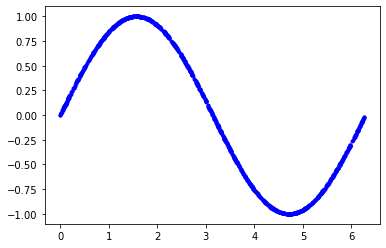

In [4]:
# Number of sample datapoints
SAMPLES = 1000

# Generate a uniformly distributed set of random numbers in the range from
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(
    low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values).astype(np.float32)

# Plot our data. The 'b.' argument tells the library to print blue dots.
plt.plot(x_values, y_values, 'b.')
plt.show()

### 2. Add Noise
Since it was generated directly by the sine function, our data fits a nice, smooth curve.

However, machine learning models are good at extracting underlying meaning from messy, real world data. To demonstrate this, we can add some noise to our data to approximate something more life-like.

In the following cell, we'll add some random noise to each value, then draw a new graph:

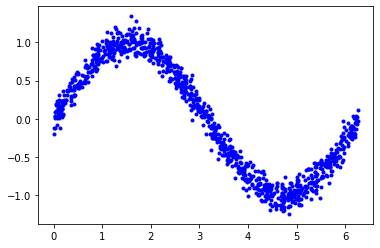

In [5]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Plot our data
plt.plot(x_values, y_values, 'b.')
plt.show()

### 3. Split the Data
We now have a noisy dataset that approximates real world data. We'll be using this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation) and after training (referred to as testing) It's important in both cases that we use fresh data that was not already used to train the model.

The data is split as follows:
  1. Training: 60%
  2. Validation: 20%
  3. Testing: 20% 

The following code will split our data and then plots each set as a different color:


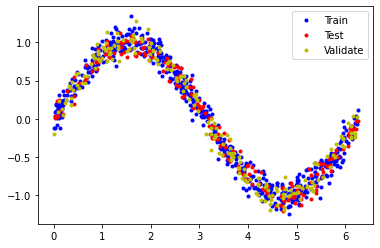

In [6]:
# We'll use 60% of our data for training and 20% for testing. The remaining 20%
# will be used for validation. Calculate the indices of each section.
TRAIN_SPLIT =  int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts.
# The second argument to np.split is an array of indices where the data will be
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that our splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


## Training

### 1. Design the Model
To make our model bigger, let's add an additional layer of neurons. The following cell redefines our model in the same way as earlier, but with 16 neurons in the first layer and an additional layer of 16 neurons in the middle:

In [7]:
model = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(keras.layers.Dense(16, activation='relu', input_shape=(1,)))

# The new second and third layer will help the network learn more complex representations
model.add(keras.layers.Dense(16, activation='relu'))

# Final layer is a single neuron, since we want to output a single value
model.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model.compile(optimizer='adam', loss="mse")

### 2. Train the Model ###

We'll now train and save the new model.

In [8]:
# Train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

# Save the model to disk
model.save(MODEL_TF)

Epoch 1/500
10/10 [==============================] - 1s 50ms/step - loss: 0.7625 - val_loss: 0.5412
Epoch 2/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4835 - val_loss: 0.4645
Epoch 3/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4354 - val_loss: 0.4478
Epoch 4/500
10/10 [==============================] - 0s 4ms/step - loss: 0.4453 - val_loss: 0.4266
Epoch 5/500
10/10 [==============================] - 0s 5ms/step - loss: 0.4087 - val_loss: 0.4085
Epoch 6/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3800 - val_loss: 0.3925
Epoch 7/500
10/10 [==============================] - 0s 5ms/step - loss: 0.3846 - val_loss: 0.3759
Epoch 8/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3563 - val_loss: 0.3594
Epoch 9/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3403 - val_loss: 0.3423
Epoch 10/500
10/10 [==============================] - 0s 4ms/step - loss: 0.3170 - val_loss: 0.3242
Epoch 11

### 3. Plot Metrics
Each training epoch, the model prints out its loss for training and validation. You can read this in the output above (note that your exact numbers may differ): 

```
Epoch 500/500
10/10 [==============================] - 0s 10ms/step - loss: 0.0121 - val_loss: 0.0115 
```


The following cell will print the same graphs we used to evaluate our original model, but showing our new training history:

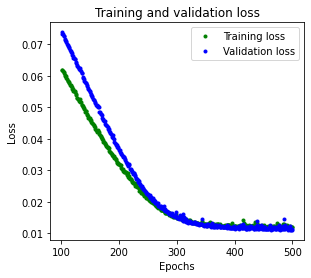

In [9]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Exclude the first few epochs so the graph is easier to read
SKIP = 100

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()



Great results!


This all means our network seems to be performing well! To confirm, let's check its predictions against the test dataset we set aside earlier:


7/7 [==============================] - 0s 1ms/step - loss: 0.0107


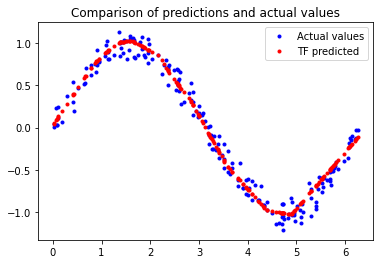

In [10]:
# Calculate and print the loss on our test dataset
test_loss = model.evaluate(x_test, y_test)

# Make predictions based on our test dataset
y_test_pred = model.predict(x_test)

# Graph the predictions against the actual values
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predicted')
plt.legend()
plt.show()

Much better! The evaluation metrics we printed show that the model has a low loss on the test data, and the predictions line up visually with our data fairly well.

The model isn't perfect; its predictions don't form a smooth sine curve. For instance, the line is almost straight when `x` is between 4.2 and 5.2. If we wanted to go further, we could try further increasing the capacity of the model, perhaps using some techniques to defend from overfitting.

However, an important part of machine learning is *knowing when to stop*. This model is good enough for our use case - which is to make some LEDs blink in a pleasing pattern.

## Generate a TensorFlow Lite Model

### 1. Generate Models with or without Quantization
We now have an acceptably accurate model. We'll use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to convert the model into a special, space-efficient format for use on memory-constrained devices.

Since this model is going to be deployed on a microcontroller, we want it to be as tiny as possible! One technique for reducing the size of a model is called [quantization](https://www.tensorflow.org/lite/performance/post_training_quantization). It reduces the precision of the model's weights, and possibly the activations (output of each layer) as well, which saves memory, often without much impact on accuracy. Quantized models also run faster, since the calculations required are simpler.

In the following cell, we'll convert the model twice: once with quantization, once without.

In [11]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open(MODEL_TFLITE, "wb").write(model_tflite)

2472

### 2. Compare Model Performance

To prove these models are accurate even after conversion and quantization, we'll compare their predictions and loss on our test dataset.

**Helper functions**

We define the `predict` (for predictions) and `evaluate` (for loss) functions for TFLite models. *Note: These are already included in a TF model, but not in  a TFLite model.*

In [12]:
def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # If required, quantize the input layer (from float to integer)
  input_scale, input_zero_point = input_details["quantization"]
  if (input_scale, input_zero_point) != (0.0, 0):
    x_test_ = x_test_ / input_scale + input_zero_point
    x_test_ = x_test_.astype(input_details["dtype"])
  
  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]
  
  # If required, dequantized the output layer (from integer to float)
  output_scale, output_zero_point = output_details["quantization"]
  if (output_scale, output_zero_point) != (0.0, 0):
    y_pred = y_pred.astype(np.float32)
    y_pred = (y_pred - output_zero_point) * output_scale

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

**1. Predictions**

In [13]:
# Calculate predictions
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_tflite, x_test)

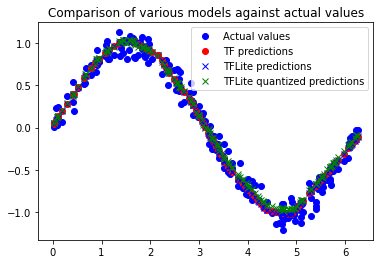

In [14]:
# Compare predictions
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite quantized predictions')
plt.legend()
plt.show()

**2. Loss (MSE/Mean Squared Error)**

In [15]:
# Calculate loss
loss_tf = model.evaluate(x_test, y_test, verbose=0)
loss_no_quant_tflite = evaluate_tflite(model_no_quant_tflite, x_test, y_test)
loss_tflite = evaluate_tflite(model_tflite, x_test, y_test)

In [16]:
# Compare loss
df = pd.DataFrame.from_records(
    [["TensorFlow", loss_tf],
     ["TensorFlow Lite", loss_no_quant_tflite],
     ["TensorFlow Lite Quantized", loss_tflite]],
     columns = ["Model", "Loss/MSE"], index="Model").round(4)
df

,Loss/MSE
Model,
TensorFlow,0.0107
TensorFlow Lite,0.0107
TensorFlow Lite Quantized,0.0117


**3. Size**

In [17]:
# Calculate size
size_tf = os.path.getsize(MODEL_TF)
size_no_quant_tflite = os.path.getsize(MODEL_NO_QUANT_TFLITE)
size_tflite = os.path.getsize(MODEL_TFLITE)

In [18]:
# Compare size
pd.DataFrame.from_records(
    [["TensorFlow", f"{size_tf} bytes", ""],
     ["TensorFlow Lite", f"{size_no_quant_tflite} bytes ", f"(reduced by {size_tf - size_no_quant_tflite} bytes)"],
     ["TensorFlow Lite Quantized", f"{size_tflite} bytes", f"(reduced by {size_no_quant_tflite - size_tflite} bytes)"]],
     columns = ["Model", "Size", ""], index="Model")

,Size,
Model,,
TensorFlow,4096 bytes,
TensorFlow Lite,2780 bytes,(reduced by 1316 bytes)
TensorFlow Lite Quantized,2472 bytes,(reduced by 308 bytes)


**Summary**

We can see from the predictions (graph) and loss (table) that the original TF model, the TFLite model, and the quantized TFLite model are all close enough to be indistinguishable - even though they differ in size (table). This implies that the quantized (smallest) model is ready to use!

*Note: The quantized (integer) TFLite model is just 300 bytes smaller than the original (float) TFLite model - a tiny reduction in size! This is because the model is already so small that quantization has little effect. Complex models with more weights, can have upto a 4x reduction in size!*

## Generate a TensorFlow Lite for Microcontrollers Model
Convert the TensorFlow Lite quantized model into a C source file that can be loaded by TensorFlow Lite for Microcontrollers.

In [19]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [872 kB]
Hit:13 http://ppa.lau

## Deploy to a Microcontroller

Follow the instructions in the [hello_world](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world) README.md for [TensorFlow Lite for MicroControllers](https://www.tensorflow.org/lite/microcontrollers/overview) to deploy this model on a specific microcontroller.

**Reference Model:** If you have not modified this notebook, you can follow the instructions as is, to deploy the model. Refer to the [`hello_world/train/models`](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/train/models) directory to access the models generated in this notebook.

**New Model:** If you have generated a new model, then update the values assigned to the variables defined in [`hello_world/model.cc`](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/examples/hello_world/model.cc) with values displayed after running the following cell.

In [20]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x94, 0x00, 0x00, 0x00, 0xc4, 0x00, 0x00, 0x00,
  0x18, 0x03, 0x00, 0x00, 0x28, 0x03, 0x00, 0x00, 0x1c, 0x09, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x6c, 0xf7, 0xff, 0xff, 0x10, 0x00, 0x00, 0x00, 0x18, 0x00, 0x00, 0x00,
  0x28, 0x00, 0x00, 0x00, 0x44, 0x00, 0x00, 0x00, 0x05, 0x00, 0x00, 0x00,
  0x73, 0x65, 0x72, 0x76, 0x65, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00,
  0x73, 0x65, 0x72, 0x76, 0x69, 0x6e, 0x67, 0x5f, 0x64, 0x65, 0x66, 0x61,
  0x75, 0x6c, 0x74, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0xc0, 0xff, 0xff, 0xff, 0x09, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x07, 0x00, 0x00, 0x00, 0x64, 0x65, 0x6e, 0x73, 0x65, 0x5f, 0x32, 0x00,
  0x01, 0x